In [1]:
!pip install qiskit
!pip install pylatexenc

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 12.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 37.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.5/241.5 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 43.6 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.5/37.5 MB 30.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.7/112.7 kB 8.7 MB/s eta 0:00:00
  Created wheel for qiskit: filename=qiskit-0.43.2-py3-none-any.whl size=7640 sha256=8802dd2e31e97bdac1c8055efaee5e8d42168bfb40c225bbb80074c5a7e6

In [2]:
from qiskit import QuantumCircuit, Aer, QuantumRegister, ClassicalRegister, execute
from sklearn import model_selection, datasets
import numpy as np

Epoch 	 Loss 	 Training Accuracy
0 	 0.236 	 0.619
1 	 0.237 	 0.615
2 	 0.237 	 0.615
3 	 0.236 	 0.601
4 	 0.236 	 0.606
5 	 0.236 	 0.606
6 	 0.236 	 0.615
7 	 0.236 	 0.615
8 	 0.237 	 0.601
9 	 0.236 	 0.615
10 	 0.236 	 0.615
11 	 0.237 	 0.606
12 	 0.236 	 0.615
13 	 0.237 	 0.615
14 	 0.237 	 0.615
15 	 0.237 	 0.606
16 	 0.237 	 0.610
17 	 0.236 	 0.615
18 	 0.236 	 0.610
19 	 0.236 	 0.615
20 	 0.236 	 0.615
21 	 0.237 	 0.619
22 	 0.236 	 0.610
23 	 0.236 	 0.601
24 	 0.237 	 0.615
25 	 0.237 	 0.615
26 	 0.237 	 0.619
27 	 0.237 	 0.615
28 	 0.237 	 0.610
29 	 0.236 	 0.615


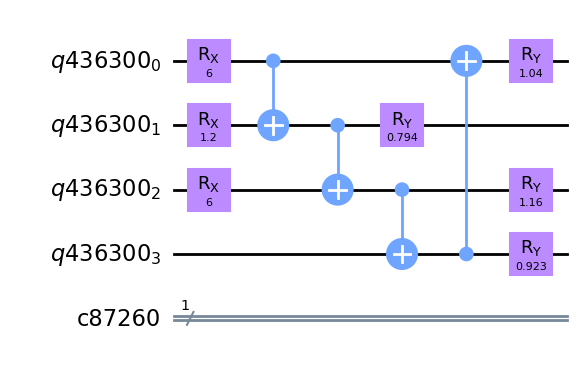

In [6]:
from qiskit import QuantumCircuit, Aer, QuantumRegister, ClassicalRegister, execute
from sklearn import model_selection, datasets
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import copy
from qiskit.visualization import circuit_drawer

 
data = pd.read_csv('/kaggle/input/10000-earthquake')

 
#X = data.iloc[:, :-1].values
X = data.iloc[:,1:-1].values
Y = data.iloc[:,-1].values
#Y = data.iloc[:, -1].values

 
label_encoder = LabelEncoder()
Y_encoded = label_encoder.fit_transform(Y)
 
    
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y_encoded, test_size=0.28, random_state=40)

# Define the number of qubits
N = 4

def feature_map(X):
    q = QuantumRegister(N)
    c = ClassicalRegister(1)
    qc = QuantumCircuit(q, c)

    for i, x in enumerate(X):
        qc.rx(x, i)

    return qc, c

def variational_circuit(qc, theta):
    for i in range(N-1):
        qc.cx(i, i+1)
    qc.cx(N-1, 0)

    for i in range(N):
        qc.ry(theta[i], i)

    return qc

def quantum_nn(X, theta, simulator=True):
    qc, c = feature_map(X) 
    qc = variational_circuit(qc, theta) 
    
    qc.measure(0, c)

    shots = 10000
    backend = Aer.get_backend('qasm_simulator')
    
    if not simulator:
        shots = 10000
        provider = IBMQ.load_account()
        backend = provider.get_backend('ibmq_athens')
    
    job = execute(qc, backend, shots=shots)
    result = job.result()
    counts = result.get_counts(qc)  
    
    return counts['1'] / shots

def loss(prediction, target):
    return (prediction - target) ** 2

def gradient(X, Y, theta):
    delta = 0.1
    grad = []
    for i in range(len(theta)):
        dtheta = copy.copy(theta)
        dtheta[i] += delta
        pred1 = quantum_nn(X, dtheta)
        pred2 = quantum_nn(X, theta)
        grad.append((loss(pred1, Y) - loss(pred2, Y)) / delta)
    return np.array(grad)

def accuracy(X, Y, theta):
    counter = 0
    for X_i, Y_i in zip(X, Y):
        prediction = quantum_nn(X_i, theta)
        if prediction < 0.5 and Y_i == 0:
            counter += 1
        elif prediction >= 0.5 and Y_i == 1:
            counter += 1
    return counter / len(Y)

eta = 0.05
loss_list = []
accuracy_list = []
theta = np.ones(N)

print('Epoch \t Loss \t Training Accuracy')

for i in range(30):
    loss_tmp = []
    for X_i, Y_i in zip(X_train, Y_train):
        prediction = quantum_nn(X_i, theta)
        loss_tmp.append(loss(prediction, Y_i))
        theta = theta - eta * gradient(X_i, Y_i, theta)
    loss_list.append(np.mean(loss_tmp))
    
    acc = accuracy(X_train, Y_train, theta)
    print(f'{i} \t {loss_list[-1]:.3f} \t {acc:.3f}')
    
    accuracy_list.append(acc)

# Create the circuit diagram
qc, c = feature_map(X_train[0])
qc = variational_circuit(qc, theta)

# Draw the circuit diagram
qc.draw(output='mpl')


Average Accuracy 0.6119266055045871
Average Loss 0.23653535548318044


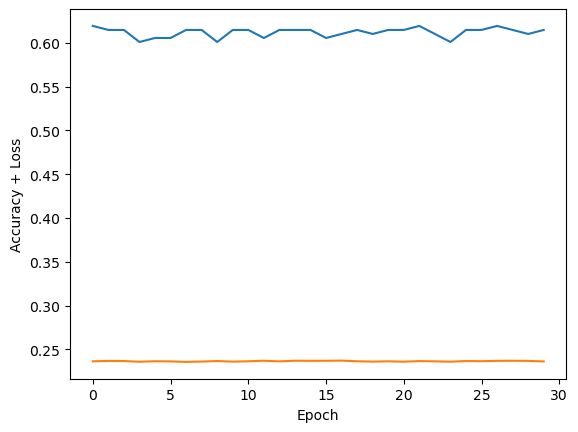

In [10]:
import matplotlib.pyplot as plt
plt.plot(accuracy_list)
plt.xlabel('Epoch')
plt.ylabel('Accuracy + Loss')
plt.show

plt.plot(loss_list)
plt.xlabel('Epoch')
plt.ylabel('Accuracy + Loss')
plt.show

from statistics import mean

average_A = mean(accuracy_list)
print("Average Accuracy", average_A)

average_L = mean(loss_list)
print("Average Loss", average_L)

In [9]:
# Calculate the final test loss
test_predictions = [quantum_nn(X_i, theta) for X_i in X_test]
final_test_loss = np.mean([loss(pred, Y_i) for pred, Y_i in zip(test_predictions, Y_test)])
print(f"Final Test Loss: {final_test_loss:.5f}")

# Calculate the final test accuracy
final_test_accuracy = accuracy(X_test, Y_test, theta)
print(f"Final Test Accuracy: {final_test_accuracy:.5f}")

Final Test Loss: 0.22006
Final Test Accuracy: 0.62791
